# ResNet50 predition and image embedding

In [1]:
import os
import sys
from typing import (
    List,
    Dict,
    Tuple,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

%matplotlib inline

In [2]:
sys.path.append("../../../lib")

In [3]:
%load_ext autoreload
%autoreload 2

from util_opencv.image import (
    validate_image,
    get_image,
    save_image,
    get_image_dimensions,
    resize_image,
    show_image,
    show_image_opencv,
    read_and_process_images,
    convert_bgr_to_rgb,
)
from util_numpy import (
    get_cosine_similarity,
    save,
    load,
)

# Resize RGB Images

1. Resize the image to (224, 224, 3) for ResNet.
2. Channel order as RGB as ResNet50Helper predict and embed expect RGB by default.

In [4]:
resized_rgb: List[np.ndarray]
processed: List[str]
skipped: List[str]

resized_rgb, processed, skipped = read_and_process_images(
    path_to_source="../data/original",
    pattern="*.jpg",
    do_resize=True,
    height=224,
    width=224,
    do_save=True,
    path_to_destination="../data/resized",
    bgr_to_rgb=True,
    skip_image_error=True
)

get_image(): OpenCV has no image reader for the image [../data/original/01218.jpg].
get_image(): OpenCV has no image reader for the image [../data/original/03055.jpg].
get_image(): OpenCV has no image reader for the image [../data/original/04035.jpg].
get_image(): OpenCV has no image reader for the image [../data/original/04036.jpg].


In [8]:
len(resized_rgb)

4031

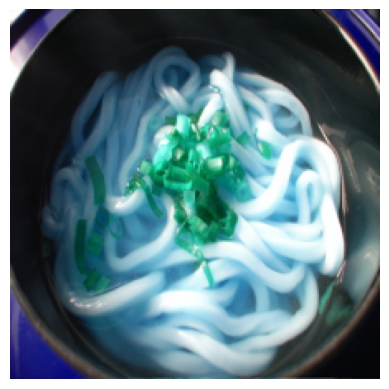

In [9]:
# show_image treats the image as BGR as per OpenCVS
show_image(resized_rgb[0])

---

# Classification by ResNet50

* [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)
* [tf.keras.applications.resnet50.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)

> ```
> tf.keras.applications.resnet50.preprocess_input(
>    x, data_format=None
>)
> """
> Args:
>     x:  
>         A floating point numpy.array or a tf.Tensor, 3D or 4D with 3 color channels, 
>         with values in the range [0, 255]. The preprocessed data are written over 
>         the input data if the data types are compatible. To avoid this behaviour, 
>         numpy.copy(x) can be used.  
> Returns: Preprocessed numpy.array or a tf.Tensor with type float32.
> """
> ```

* [tf.keras.applications.resnet50.decode_predictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/decode_predictions)

> Returns: A list of lists of top class prediction tuples ```(class_name, class_description, score)```. One list of tuples per sample in batch input.



* [Usage examples for image classification models - Classify ImageNet classes with ResNet50](https://keras.io/api/applications/#usage-examples-for-image-classification-models)

> ```
> from tensorflow.keras.applications.resnet50 import ResNet50
> from tensorflow.keras.preprocessing import image
> from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
> import numpy as np
> 
> model = ResNet50(weights='imagenet')
> 
> img_path = 'elephant.jpg'
> img = image.load_img(img_path, target_size=(224, 224))
> x = image.img_to_array(img)
> x = np.expand_dims(x, axis=0)
> x = preprocess_input(x)
> 
> preds = model.predict(x)
> # decode the results into a list of tuples (class, description, probability)
> # (one such list for each sample in the batch)
> print('Predicted:', decode_predictions(preds, top=3)[0])
> # Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]
> ```

In [10]:
from keras.models import (
    Model, 
    Sequential
)
import tensorflow as tf
from tensorflow.keras.applications import (
#    ResNet152V2,
    ResNet50,
)
from tensorflow.keras.applications.resnet50 import (
     preprocess_input, 
     decode_predictions
 )

In [11]:
%load_ext autoreload
%autoreload 2

from util_tf.resnet50 import (
    preprocess_rgb_image_for_resnet,
    ResNet50Helper,
    Vectorizer,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Model

In [12]:
resnet: ResNet50Helper = ResNet50Helper()
model: Model = resnet.model

In [13]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

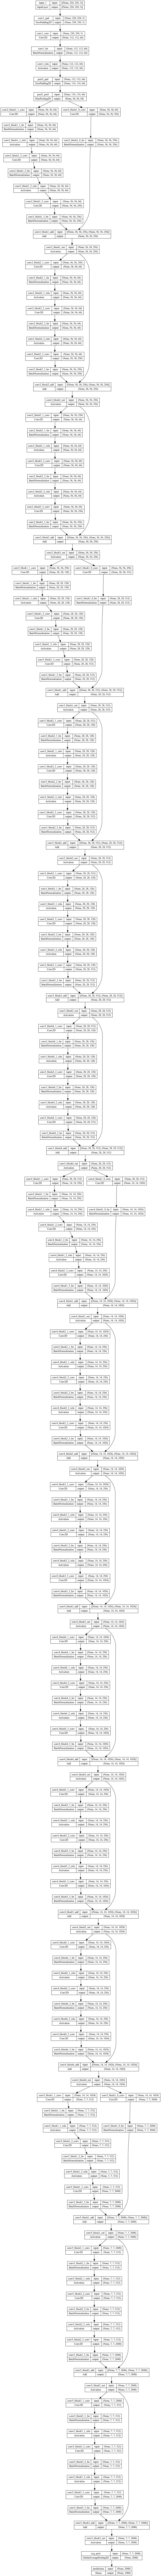

In [14]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True
)

## Image to Predict

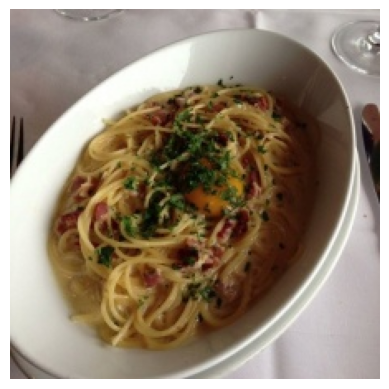

In [15]:
image = get_image(path="../data/resized/00004.jpg")
show_image(image)

### Predict

In [16]:
# image is in BGR loaded by OpenCV imread
resnet.predict(images=image, top=3, bgr_to_rgb=True)

2023-01-22 23:05:38.820352: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 470ms/step


[[('n07831146', 'carbonara', 0.9956995),
  ('n07579787', 'plate', 0.0025090328),
  ('n07716906', 'spaghetti_squash', 0.000849533)]]

## Batch Predictions

### Load Images as RGB of shape (N, 224, 224, 3)

In [17]:
step: int = 10
images_to_predict: np.ndarray = np.array(resized_rgb)
# Image is RGB 
predictions = resnet.predict(images_to_predict[::step,])   
for name, pred in zip(processed[::step], predictions):
    print(f"{name}:[{pred}]")

13/13 [==============================] - 10s 794ms/step
00000.jpg:[[('n04263257', 'soup_bowl', 0.96380866), ('n07831146', 'carbonara', 0.014287813), ('n07714990', 'broccoli', 0.005780516)]]
00010.jpg:[[('n07579787', 'plate', 0.76719064), ('n07583066', 'guacamole', 0.045539215), ('n07697537', 'hotdog', 0.038528513)]]
00020.jpg:[[('n02776631', 'bakery', 0.7832293), ('n07875152', 'potpie', 0.0644003), ('n04476259', 'tray', 0.050149072)]]
00030.jpg:[[('n04263257', 'soup_bowl', 0.8377435), ('n07584110', 'consomme', 0.050771046), ('n07930864', 'cup', 0.012542519)]]
00040.jpg:[[('n07716906', 'spaghetti_squash', 0.2249125), ('n07697537', 'hotdog', 0.15445204), ('n07717556', 'butternut_squash', 0.12349708)]]
00050.jpg:[[('n07873807', 'pizza', 0.38208592), ('n04270147', 'spatula', 0.34398606), ('n04111531', 'rotisserie', 0.13415931)]]
00060.jpg:[[('n07584110', 'consomme', 0.9964401), ('n07920052', 'espresso', 0.0030429175), ('n04263257', 'soup_bowl', 0.0002774758)]]
00070.jpg:[[('n07697313', 'ch

## Feature Extractor for image embedding

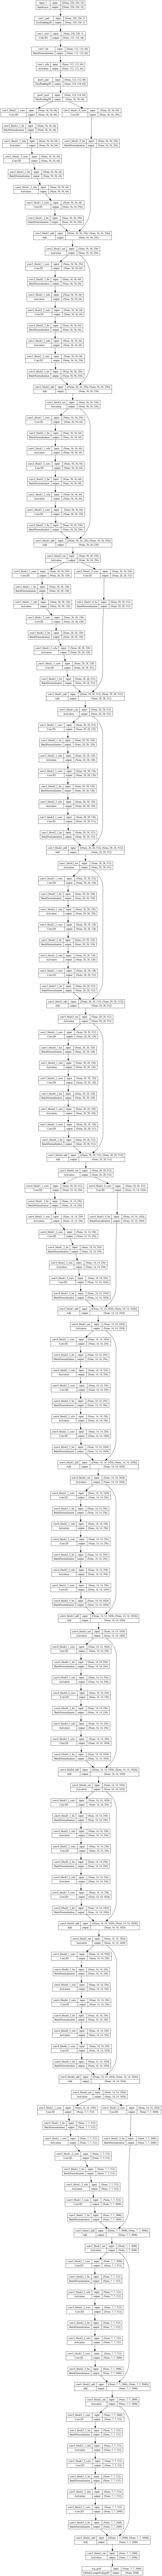

In [18]:
feature_extractor = resnet.feature_extractor
tf.keras.utils.plot_model(
    feature_extractor,
    show_shapes=True,
    show_layer_names=True
)

In [19]:
del resnet
del feature_extractor

---

# Feature Extraction using ResNet50

In [20]:
vectorizer: Vectorizer = Vectorizer()

In [21]:
embeddings: np.ndarray = vectorizer.transform(
    images=resized_rgb, 
    bgr_to_rgb=False
)

126/126 [==============================] - 108s 852ms/step


In [22]:
get_cosine_similarity(x=embeddings[0], y=embeddings[1])

array([[0.5704149]], dtype=float32)

In [24]:
save(array=embeddings, path_to_file="../data/result/image_embeddings.npy")

'../data/result/image_embeddings.npy'

In [34]:
processed[1370]

'01371.jpg'

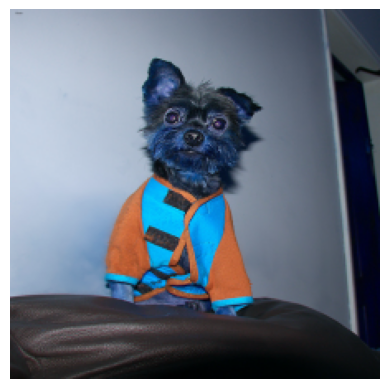

In [37]:
show_image(resized_rgb[1360])

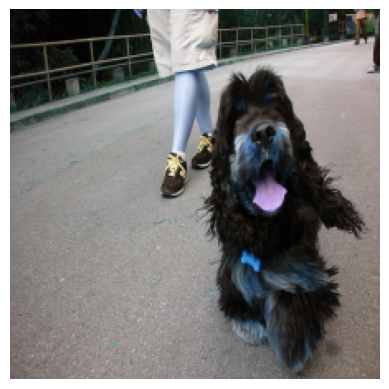

In [33]:
show_image(resized_rgb[1370])

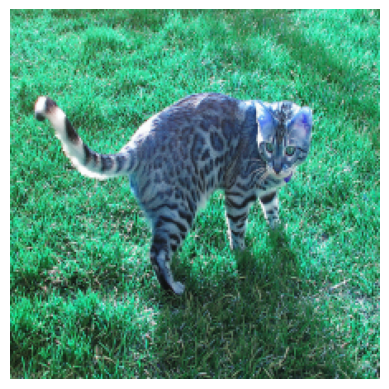

In [46]:
show_image(resized_rgb[1371])

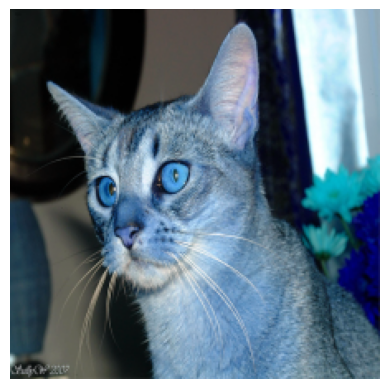

In [51]:
show_image(resized_rgb[1311])

# Similarities

In [38]:
get_cosine_similarity(x=embeddings[1370], y=embeddings[1360])

array([[0.5681502]], dtype=float32)

In [39]:
get_cosine_similarity(x=embeddings[1370], y=embeddings[1371])

array([[0.37798586]], dtype=float32)

In [52]:
get_cosine_similarity(x=embeddings[1311], y=embeddings[1371])

array([[0.42082584]], dtype=float32)